In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader as web
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

In [163]:

def get_random_tickers(n, ticklist):
    if n >len(ticklist):
        raise Exception('n is bigger than ticklist')
    return np.random.choice(ticklist, size=n, replace=False)
RSVE = []

# Our initial ticklist

ticklist = ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BEI.DE', 'BMW.DE', 'CON.DE', 'DAI.DE', 'DBK.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE',
 'FRE.DE', 'HEI.DE', 'HEN3.DE', 'LHA.DE', 'LIN.DE', 'MRK.DE', 'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'TKA.DE', 'VOW3.DE']

# The 7 tickers chosen randomly from this ticklist

ticklist = get_random_tickers(7, ticklist)
ticklist = ['LIN.DE', 'HEN3.DE', 'DAI.DE', 'FME.DE', 'MUV2.DE', 'SIE.DE', 'DBK.DE']

print(ticklist)


d0 = '2001-01-01' # begining of the waiting period
d1 = '2004-01-01' # begining of the CV period
d2 = '2006-01-01' # begining of the test period
d3 = '2008-01-01' # end of the test period

norm=True
lbd = 0.2 # history weight metric
alpha = 0.09 # risk management metric
cst = 10 #weight metric
delta = 0.91

dtes = pd.read_csv('trading_days.csv', index_col=0)
tempdt = dtes.copy()
tempdt.set_index('Buy', drop=True, inplace=True)
tempdt.index = pd.to_datetime(tempdt.index)

Y = []
X = pd.DataFrame(columns=['Date', 'EMA10', 'EMA16', 'EMA22', 'SMA10', 'SMA16', 'SMA22','ValueAtRisk', 
                       'Bollu20', 'Bollu26', 'Bollu32', 'Bolld20', 'Bolld26', 'Bolld32',
                       'Mom12', 'Mom18', 'Mom24', 'ACC12', 'ACC18', 'ACC24', 'ROC10', 'ROC16',
                       'ROC22', 'MACD1812', 'MACD2412','MACD3012', 'MACDS18129', 'MACDS24129', 'MACDS30129', 
                       'RSI8', 'RSI14', 'RSI20', 'OBV', 'CHV1010', 'CHV1016', 'CHV1022',
                       'FastK12', 'FastD12', 'FastK18', 'SlowK12', 'FastD18', 'SlowD12',
                       'FastK24', 'SlowK18', 'FastD24', 'SlowD18', 'SlowK24', 'SlowD24',
                       'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Ticker',
                       'Month', 'DAX', 'ADL', 'Type', 'Y'])
dax = web.get_data_yahoo('^GDAXI', start=d0, end=d3)
prices = pd.DataFrame(columns=['Ticker', 'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Date'])

# Generate the X matrix and Y matrix and make them have only trading days
for tick in ticklist:
    if norm:
        temp = pd.read_csv('tickDataNorm/'+ str(delta).replace('.', '') +'/' + tick.replace('.', '') +'.csv', index_col=0)
    else:
        temp = pd.read_csv('tickData/'+ str(delta).replace('.', '') +'/' + tick.replace('.', '') +'.csv', index_col=0)
    prices = pd.concat([prices, temp.loc[:, ['Ticker', 'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Date']]],axis=0, ignore_index=True, sort=False,copy=True)
    # Select dates around events
    temp.set_index('Date', inplace=True, drop=True)
    temp.index = pd.to_datetime(temp.index)
    B = temp.loc[pd.to_datetime(dtes.Buy), 'Close']
    S = temp.loc[pd.to_datetime(dtes.Sell), 'Close']
    temp = temp.loc[tempdt.index, :]
    temp['Y'] = 100*(S.values-B.values)/B.values
    
    mask = np.logical_not(np.isnan(temp['Y'].values))
    temp = temp.loc[mask, :]
    if norm:
        temp.loc[:,'High'] = temp.loc[:,'Norm_High']
        temp.loc[:,'Low'] = temp.loc[:,'Norm_Low']
        temp.loc[:,'Open'] = temp.loc[:,'Norm_Open']
        temp.loc[:,'Close'] = temp.loc[:,'Norm_Close']
        temp.loc[:,'AdjClose'] = temp.loc[:,'Norm_AdjClose']
    #temp = temp.loc[pd.to_datetime(dtes.Buy), :]
    temp['Month'] = temp.index.month
    temp['Date'] = temp.index
    temp['DAX'] = dax.loc[temp.index, 'Adj Close']
    temp.loc[:,'Type'] = tempdt.loc[mask, 'Type'].values
    temp = temp.loc[:,['Date', 'EMA10', 'EMA16', 'EMA22', 'SMA10', 'SMA16', 'SMA22','ValueAtRisk', 
                       'Bollu20', 'Bollu26', 'Bollu32', 'Bolld20', 'Bolld26', 'Bolld32',
                       'Mom12', 'Mom18', 'Mom24', 'ACC12', 'ACC18', 'ACC24', 'ROC10', 'ROC16',
                       'ROC22', 'MACD1812', 'MACD2412','MACD3012', 'MACDS18129', 'MACDS24129', 'MACDS30129', 
                       'RSI8', 'RSI14', 'RSI20', 'OBV', 'CHV1010', 'CHV1016', 'CHV1022',
                       'FastK12', 'FastD12', 'FastK18', 'SlowK12', 'FastD18', 'SlowD12',
                       'FastK24', 'SlowK18', 'FastD24', 'SlowD18', 'SlowK24', 'SlowD24',
                       'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Ticker',
                       'Month', 'DAX', 'ADL','Type', 'Y']]
    
    
    X = pd.concat([X, temp], axis=0, ignore_index=True, copy=True, sort=False)

T = X.Ticker.unique()
tickdict = dict(zip(T, range(len(T))))
for tick in T:
    X.loc[X.Ticker==tick,'Ticker']= tickdict[tick]


X.sort_values(by=['Date', 'Ticker'], inplace=True)
X.set_index('Date', drop=True, inplace=True)
X = X.loc[((X.index>=pd.to_datetime(d0)) & (X.index<=pd.to_datetime(d3))), :]
C = ['EMA10', 'EMA16', 'EMA22', 'SMA10', 'SMA16', 'SMA22', 'ValueAtRisk',
       'Bollu20', 'Bollu26', 'Bollu32', 'Bolld20', 'Bolld26', 'Bolld32',
       'Mom12', 'Mom18', 'Mom24', 'ACC12', 'ACC18', 'ACC24', 'ROC10', 'ROC16',
       'ROC22', 'MACD1812', 'MACD2412', 'MACD3012', 'MACDS18129', 'MACDS24129',
       'MACDS30129', 'RSI8', 'RSI14', 'RSI20', 'OBV', 'CHV1010', 'CHV1016',
       'CHV1022', 'FastK12', 'FastD12', 'FastK18', 'SlowK12', 'FastD18',
       'SlowD12', 'FastK24', 'SlowK18', 'FastD24', 'SlowD18', 'SlowK24',
       'SlowD24', 'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose',
       'Month', 'DAX', 'ADL','Type', 'Ticker']
Xtrain1 = X.loc[((X.index>pd.to_datetime(d0)) & (X.index<=pd.to_datetime(d1))), C]
Xcv1 = X.loc[((X.index>pd.to_datetime(d1)) & (X.index<=pd.to_datetime(d2))), C]
Ytrain1 = X.loc[((X.index>pd.to_datetime(d0)) & (X.index<=pd.to_datetime(d1))), 'Y']
Ycv1 = X.loc[((X.index>pd.to_datetime(d1)) & (X.index<=pd.to_datetime(d2))), 'Y']

['LIN.DE', 'HEN3.DE', 'DAI.DE', 'FME.DE', 'MUV2.DE', 'SIE.DE', 'DBK.DE']


C:\Users\renze\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
C:\Users\renze\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Neural Network

In [166]:
import torch
import torch.autograd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time


In [167]:
class MLP(nn.Module):
    def __init__(self, size_list, dropout = False, dropoutProb = 0.1, batchNorm = False):
        super(MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
            
            if batchNorm:
                layers.append(nn.BatchNorm1d(size_list[i+1]))
                
            if dropout:
                layers.append(nn.dropout, p = dropoutProb)
            
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        
        # Unpack the list
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)



# Function for training

In [168]:
def train_epoch(model, optimizer, X_train, y_train, criterion):
    model.train()
    
    start_time = time.time()

    optimizer.zero_grad()  

    outputs = model(X_train)
    
    loss = criterion(outputs, y_train)
    
    running_loss = loss.item()

    loss.backward()
    
    optimizer.step()
    
    end_time = time.time()
    
    #print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

# Optimizer can be 'SGD', 'RMSprop', 'ADAM', 
def nnTrain(X_train, y_train, size_list, dropout = False, dropoutProb = 0.1, batchNorm = False, 
                optimizer = 'SGD', lr = 0.01, n_epochs = 100):
    
    model = MLP(size_list)
    
    criterion = nn.MSELoss()
    
    if optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr = lr)
    if optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr = lr)
    if optimizer == 'ADAM':
        optimizer = optim.ADAM(model.parameters(), lr = lr)
    
    Train_loss = []
    
    for i in range(n_epochs):
        train_loss = train_epoch(model, optimizer, X_train, y_train, criterion)
        Train_loss.append(train_loss)
    
    return model, Train_loss

# Function for testing

In [170]:
def nnTest(model, X_test, y_test):
    criterion = nn.MSELoss()
    with torch.no_grad():
        model.eval()        

        outputs = model(X_test)

        loss = criterion(outputs, y_test).detach()
        running_loss = loss.item()
        
        return running_loss

# Normalization

In [180]:
Xmean = np.mean(Xtrain1)
Xstdev = np.std(Xtrain1)
Xtrain2 = (Xtrain1-Xmean)/Xstdev
Xcv2 = (Xcv1-Xmean)/Xstdev

In [173]:
X_train = torch.autograd.Variable(torch.Tensor(Xtrain2.values.astype(float)))
y_train = torch.autograd.Variable(torch.Tensor(Ytrain1.values.astype(float)))

X_test = torch.autograd.Variable(torch.Tensor(Xcv2.values.astype(float)))
y_test = torch.autograd.Variable(torch.Tensor(Ycv1.values.astype(float)))

# match the shapes of output and target
y_train = y_train.view(len(Ytrain1),1) 
size_list = [X_train.shape[1], 20, 20, y_train.shape[1]]

# Testing

In [176]:
model, Train_loss = nnTrain(X_train, y_train, size_list, dropout = True, dropoutProb = 0.1, batchNorm = True, 
                optimizer = 'SGD', lr = 0.01, n_epochs = 1000)

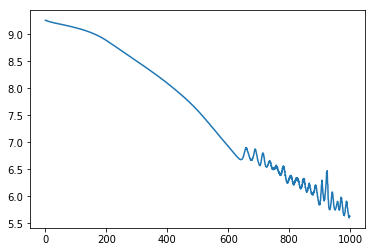

In [177]:
plt.plot(Train_loss)

In [178]:
test_loss = nnTest(model, X_test, y_test)